In [79]:
import pandas as pd
import numpy as np
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [80]:
raw_df = pd.read_excel('../to_use datasets/complete_dataset.xlsx', engine="openpyxl")

In [81]:
df_clean = pd.read_csv('../to_use datasets/macro_indicators + additional_features.csv')

In [82]:
raw_df.columns

Index(['Date', 'CPI', 'Exchange_Rate(Naira to USD)', 'Interest_Rate',
       'Money_Supply', 'Interbank_Call _rate', 'prime_Lending _rate',
       'Currency _in_Circulation', 'monetary_policy_rate',
       'treasury_Bill_rate'],
      dtype='object')

In [83]:
base_features = ['Exchange_Rate(Naira to USD)', 'Interest_Rate',
       'Money_Supply', 'Interbank_Call _rate', 'prime_Lending _rate',
       'Currency _in_Circulation', 'monetary_policy_rate',
       'treasury_Bill_rate']

dates = raw_df['Date']
y = raw_df['CPI']

In [84]:
X = raw_df[base_features]

In [85]:
# Feature scaling (important for SVR)
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).ravel()

In [86]:
# Time-aware split (no shuffle)
X_train, X_test, y_train, y_test, dates_train, dates_test = train_test_split(
    X_scaled, y_scaled, dates, test_size=0.2, shuffle=False
)

In [87]:
svr = SVR(kernel='linear')

In [88]:
svr.fit(X_train, y_train)

,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,tol,0.001
,C,1.0
,epsilon,0.1
,shrinking,True
,cache_size,200
,verbose,False
,max_iter,-1


In [89]:
# Predict and inverse scale
y_pred_scaled = svr.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
y_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1)).ravel()

# Evaluate
rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
r2 = r2_score(y_actual, y_pred)
print(f"SVR RMSE: {rmse:.3f}")
print(f"SVR R²: {r2:.3f}")

SVR RMSE: 5.610
SVR R²: 0.036


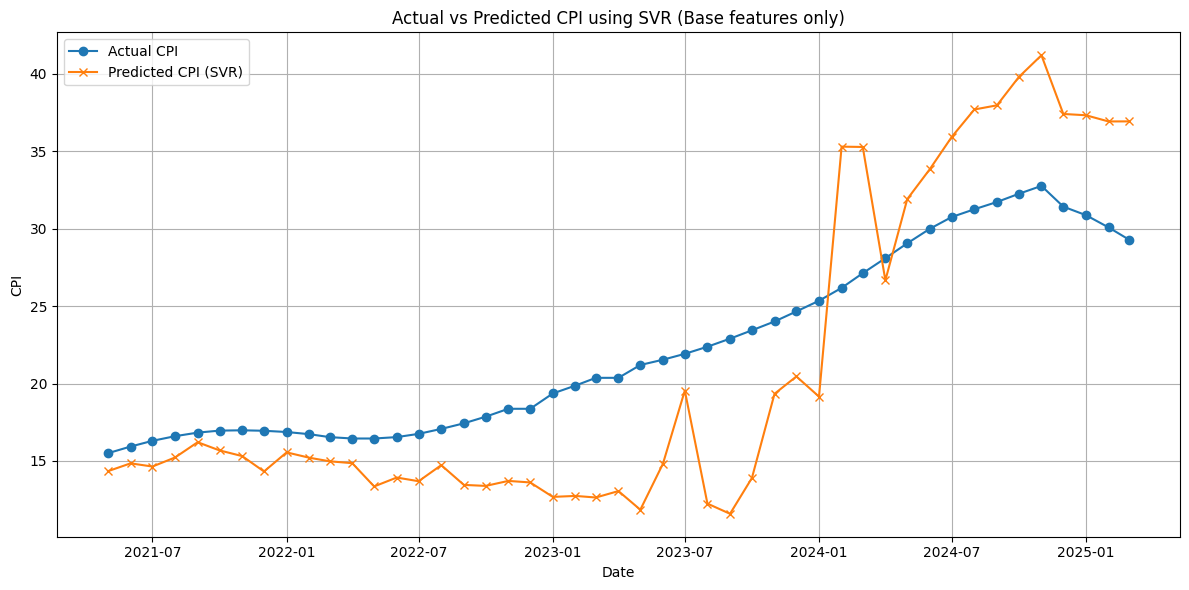

In [90]:
# Plot actual vs predicted CPI
plt.figure(figsize=(12, 6))
plt.plot(dates_test, y_actual, label='Actual CPI', marker='o')
plt.plot(dates_test, y_pred, label='Predicted CPI (SVR)', marker='x')
plt.title("Actual vs Predicted CPI using SVR (Base features only)")
plt.xlabel("Date")
plt.ylabel("CPI")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Base + Added features

In [91]:
# Load your cleaned data
df = df_clean.copy()

# Final selected features
final_features = [
    'exchange_rate(naira_to_usd)', 'interest_rate', 'money_supply',
    'interbank_call__rate', 'prime_lending__rate',
    'currency__in_circulation', 'monetary_policy_rate', 'treasury_bill_rate',
    'month', 'quarter', 'is_december',
    'cpi_lag1', 'cpi_lag3', 'cpi_rollmean3', 'cpi_rollstd3'
]

In [92]:
X = df[final_features]
y = df['cpi']
dates = df['date']

# Feature scaling (important for SVR)
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).ravel()

In [93]:
# Time-aware split (no shuffle)
X_train, X_test, y_train, y_test, dates_train, dates_test = train_test_split(
    X_scaled, y_scaled, dates, test_size=0.2, shuffle=False
)

In [94]:
svr = SVR(kernel='linear')

In [95]:
svr.fit(X_train, y_train)

,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,tol,0.001
,C,1.0
,epsilon,0.1
,shrinking,True
,cache_size,200
,verbose,False
,max_iter,-1


In [96]:
# Predict and inverse scale
y_pred_scaled = svr.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
y_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1)).ravel()

# Evaluate
rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
r2 = r2_score(y_actual, y_pred)
print(f"SVR RMSE: {rmse:.3f}")
print(f"SVR R²: {r2:.3f}")

SVR RMSE: 0.894
SVR R²: 0.975


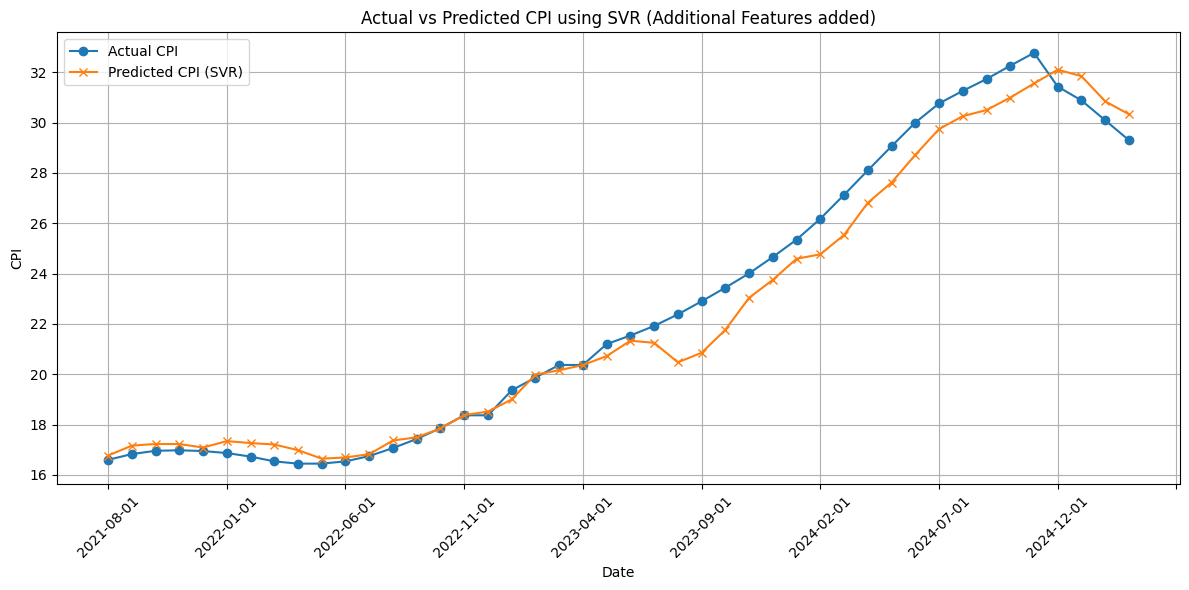

In [97]:
# Plot actual vs predicted CPI
plt.figure(figsize=(12, 6))
plt.plot(dates_test, y_actual, label='Actual CPI', marker='o')
plt.plot(dates_test, y_pred, label='Predicted CPI (SVR)', marker='x')
plt.title("Actual vs Predicted CPI using SVR (Additional Features added)")
plt.xlabel("Date")
plt.ylabel("CPI")
plt.legend()
plt.grid(True)

# Rotate date labels and format ticks
plt.xticks(rotation=45)  # Rotate by 45 degrees

plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True, prune='both'))
plt.tight_layout()
plt.show()


### Using  Grid Search Tuning Method

### Hyperparameter tuning process

In [98]:
# SVR and hyperparameter grid
param_grid = {
    'C': [1, 10, 100],
    'gamma': ['scale', 0.01, 0.001],
    'epsilon': [0.01, 0.1, 0.5]
}


grid = GridSearchCV(svr, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid.fit(X_train, y_train)

# Best SVR model
best_svr = grid.best_estimator_
print("Best Params:", grid.best_params_)

# Predict and inverse scale
y_pred_scaled = best_svr.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
y_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1)).ravel()

# Evaluation
rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
r2 = r2_score(y_actual, y_pred)
print(f"SVR RMSE: {rmse:.3f}")
print(f"SVR R²: {r2:.3f}")

Best Params: {'C': 10, 'epsilon': 0.01, 'gamma': 'scale'}
SVR RMSE: 0.205
SVR R²: 0.999


#### `Overfitting Check`

In [99]:
# Predict on training set
y_train_pred_scaled = best_svr.predict(X_train)
y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled.reshape(-1, 1)).ravel()
y_train_actual = scaler_y.inverse_transform(y_train.reshape(-1, 1)).ravel()

# Evaluate train error
train_rmse = np.sqrt(mean_squared_error(y_train_actual, y_train_pred))
train_r2 = r2_score(y_train_actual, y_train_pred)

print(f"Train RMSE: {train_rmse:.3f}")
print(f"Train R²: {train_r2:.3f}")


Train RMSE: 0.068
Train R²: 0.999


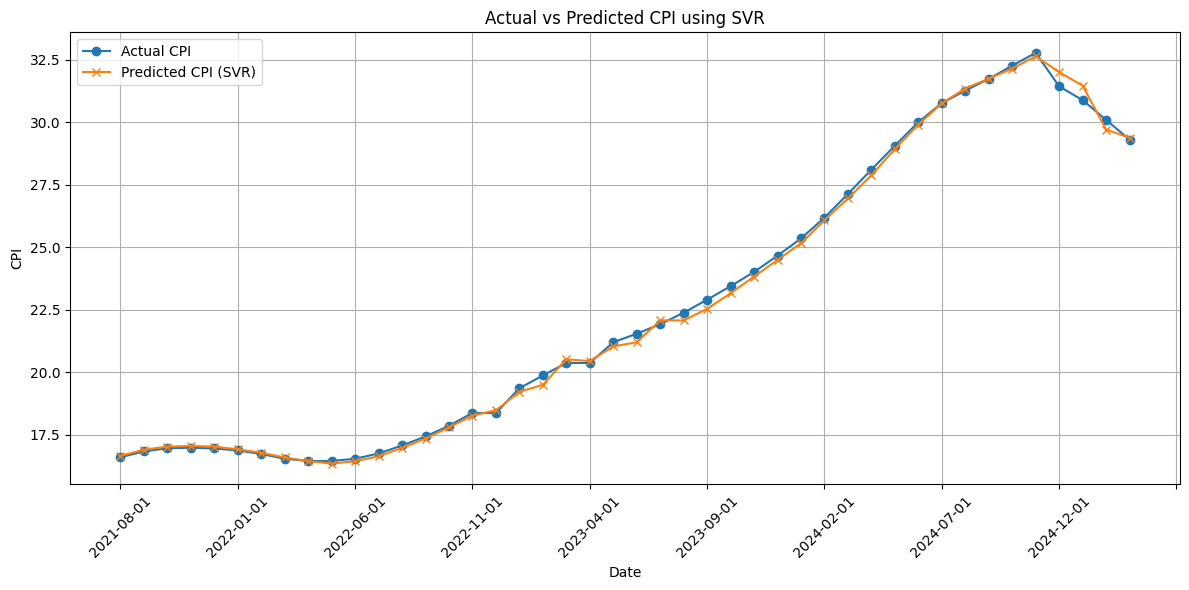

In [100]:
# Plot actual vs predicted CPI
plt.figure(figsize=(12, 6))
plt.plot(dates_test, y_actual, label='Actual CPI', marker='o')
plt.plot(dates_test, y_pred, label='Predicted CPI (SVR)', marker='x')
plt.title("Actual vs Predicted CPI using SVR")
plt.xlabel("Date")
plt.ylabel("CPI")
plt.legend()
plt.grid(True)

# Rotate date labels and format ticks
plt.xticks(rotation=45)  # Rotate by 45 degrees

plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True, prune='both'))

plt.tight_layout()
plt.show()

### SVR with RandomizedSearchCV

In [101]:
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import uniform, reciprocal
import numpy as np

# Scale features and target
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).ravel()

# Train-test split
X_train, X_test, y_train, y_test, dates_train, dates_test = train_test_split(
    X_scaled, y_scaled, dates, test_size=0.2, shuffle=False
)

# Define SVR model
svr = SVR(kernel='linear')

# Define hyperparameter search space
param_distributions = {
    'C': reciprocal(1e-1, 1e3),           # log-uniform: good for C
    'epsilon': uniform(0.001, 0.5),       # uniform range for epsilon
    'gamma': reciprocal(1e-4, 1e-1)       # log-uniform for gamma
}

# Set up randomized search
random_search = RandomizedSearchCV(
    estimator=svr,
    param_distributions=param_distributions,
    n_iter=50,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit search
random_search.fit(X_train, y_train)

# Get best model
best_svr = random_search.best_estimator_
print("Best Parameters:", random_search.best_params_)

# Predict and inverse scale
y_pred_scaled = best_svr.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
y_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1)).ravel()

# Evaluate
rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
r2 = r2_score(y_actual, y_pred)

print(f"RandomizedSearch SVR RMSE: {rmse:.3f}")
print(f"RandomizedSearch SVR R²: {r2:.3f}")


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'C': np.float64(1.3783578294796377), 'epsilon': np.float64(0.0194434736772664), 'gamma': np.float64(0.0067405137963740475)}
RandomizedSearch SVR RMSE: 0.282
RandomizedSearch SVR R²: 0.998


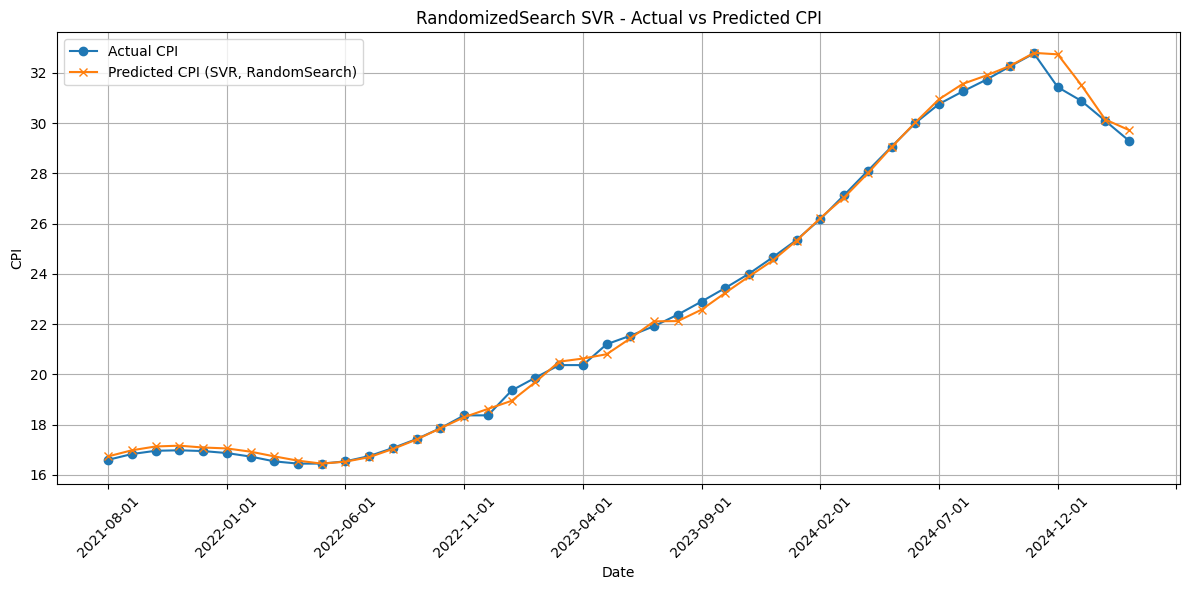

In [102]:
plt.figure(figsize=(12, 6))
plt.plot(dates_test, y_actual, label='Actual CPI', marker='o')
plt.plot(dates_test, y_pred, label='Predicted CPI (SVR, RandomSearch)', marker='x')
plt.title("RandomizedSearch SVR - Actual vs Predicted CPI")
plt.xlabel("Date")
plt.ylabel("CPI")
plt.legend()
plt.grid(True)

# Rotate date labels and format ticks
plt.xticks(rotation=45)  # Rotate by 45 degrees

plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True, prune='both'))

plt.tight_layout()
plt.show()

In [103]:
# Predict on training set
y_train_pred_scaled = best_svr.predict(X_train)
y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled.reshape(-1, 1)).ravel()
y_train_actual = scaler_y.inverse_transform(y_train.reshape(-1, 1)).ravel()

# Evaluate train error
train_rmse = np.sqrt(mean_squared_error(y_train_actual, y_train_pred))
train_r2 = r2_score(y_train_actual, y_train_pred)

print(f"Train RMSE: {train_rmse:.3f}")
print(f"Train R²: {train_r2:.3f}")


Train RMSE: 0.099
Train R²: 0.999
